In [34]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d 
from scipy.signal import medfilt
from sklearn import linear_model as lm
from scipy import optimize

%matplotlib inline

In [35]:
files = glob.glob('Results/Final/*.csv')

files_array = []
for file in files:
    files_array.append(pd.DataFrame.from_csv(file))

df = pd.concat(files_array)
df.index = range(len(df))
df.head()

,flow,volume,vortex,side_f,side_h1,side_blended,PWG,meta
0,NaN,NaN,NaN,NaN,NaN,NaN,ATS24*13.0,Sidestack A (Red)Downstream B (Green)Mouthpiec...
1,NaN,NaN,NaN,NaN,NaN,NaN,ATS24*13.0,Sidestack A (Red)Downstream B (Green)Mouthpiec...
2,NaN,NaN,NaN,NaN,NaN,NaN,ATS24*13.0,Sidestack A (Red)Downstream B (Green)Mouthpiec...
3,NaN,NaN,NaN,NaN,NaN,NaN,ATS24*13.0,Sidestack A (Red)Downstream B (Green)Mouthpiec...
4,NaN,NaN,NaN,NaN,NaN,NaN,ATS24*13.0,Sidestack A (Red)Downstream B (Green)Mouthpiec...


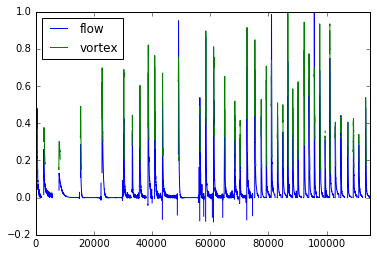

In [36]:
(df[['flow','vortex']]/df[['flow','vortex']].max()).plot()

In [37]:
df_grouped = df.groupby('meta')

8
8
10
9
2
3
3
1
4


meta
Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)             8
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)       10
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)         9
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)        2
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)         3
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)        3
Sidestack A (Red)Downstream B (Green)Mouthpiece A (Red)0% Infill (Blue)               1
Sidestack A (Red)Downstream C (Yellow)Mouthpiece D (Red - Closed)0% Infill (Blue)     4
dtype: int64

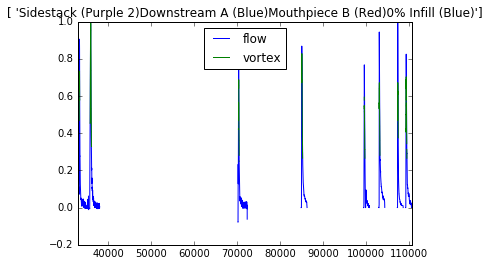

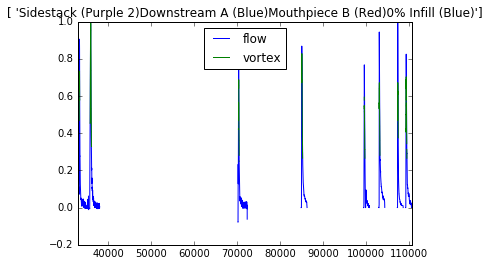

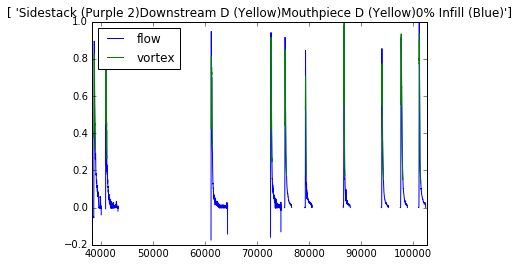

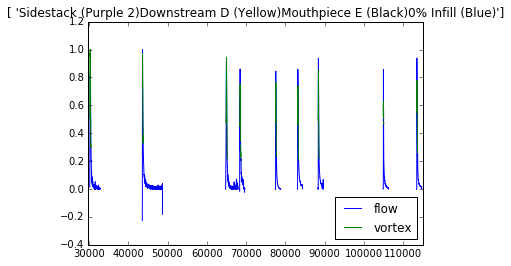

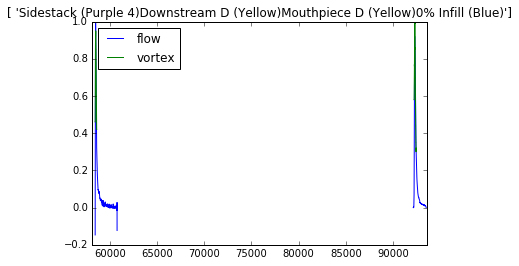

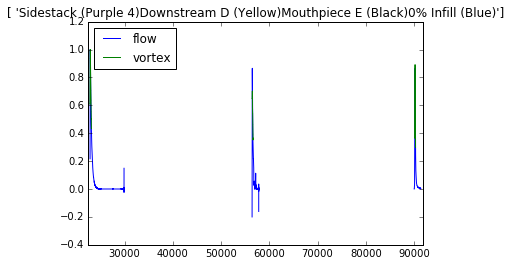

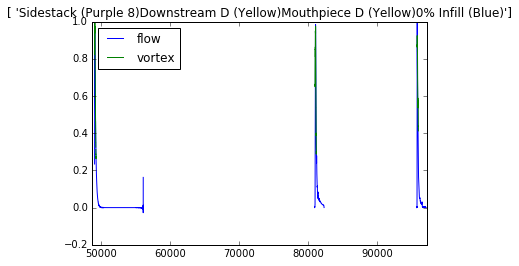

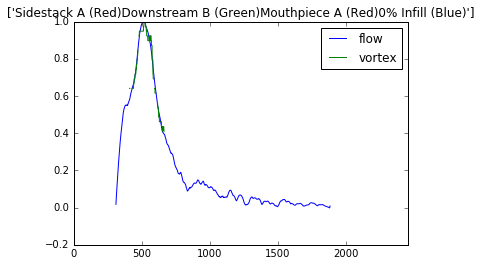

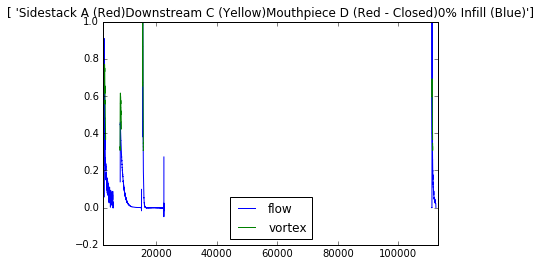

In [38]:
def analyze_groups(grp):
    print len(grp['PWG'].unique())
    plt.figure()
    (grp[['flow','vortex']]/grp[['flow','vortex']].max()).plot()
    plt.title(grp.meta.unique())
    return len(grp['PWG'].unique())
    
df_result = df_grouped.apply(analyze_groups)
df_result

In [39]:
def linear_mix( start, end ):
    mix = np.linspace(1, 0, len(start))
    return mix * start + (1 - mix) * end

# We use no offset, e.g. we asymptotically approach zero
def exponential_tail(x, a0, a1, b0, b1):
    return a0 * np.exp(-b0*x) + a1 * np.exp(-b1*x*x)

def expexp_tail(x, a0, b0):
    return a0 * np.exp(np.exp(-b0*x))

def make_p0(tail_model, a, b):
    if tail_model == exponential_tail:
        return [a, a, b, b]
    if tail_model == expexp_tail:
        return [a, b]
    return None

# Given a signal x, with tail x[start_idx:end_idx], fit the funciton tail_model
# (which should be exponential_tail, or expexp_tail) to the tail, and modify x
# such that it decays according to tail_model.  Return x
def fit_tail( tail_model, x, start_idx, end_idx, mixfunc=linear_mix ):
    x = np.copy(x)
    x_tail = x[start_idx:end_idx+(end_idx-start_idx)/10]
    a = x_tail[0]
    b = 0.01
    
    nans = np.isnan(x_tail)
    xx = np.array(range(len(x_tail)))
    popt, pcov = optimize.curve_fit(tail_model, xx[~nans], x_tail[~nans], p0=make_p0(tail_model, a, b))

    
    gen_tail = exponential_tail(np.arange(len(x) - start_idx), *popt)
    x_tail[nans] = gen_tail[nans]
    x[start_idx:end_idx+(end_idx-start_idx)/10] = x_tail
    x[start_idx:end_idx] = mixfunc(x[start_idx:end_idx], gen_tail[:end_idx-start_idx])
    x[end_idx:] = gen_tail[end_idx-start_idx:]
    return x


def fit_head(y, peak_idx, first_finite):
    # Create a copy of x so the original isn't modified
    y = np.copy(y)
    # Shift peak_idx so the first slope is actually steep
#     peak_idx = np.copy(peak_idx) - 10
    
    # Define slope window
    window = 30
    start_idx = int(0.25 * (peak_idx - first_finite))
    for i in range(start_idx, 0, -1):
        start_slope = np.nanmean(np.diff(y[peak_idx - i - window : peak_idx - i + 1]))
        if start_slope > 0:
#             print i, start_slope
            peak_idx = peak_idx - i
            break
        
    init_start_slope = np.nanmean(np.diff(y[peak_idx - 10 : peak_idx + 1]))
    if start_slope <= 0 or init_start_slope > start_slope:
        start_slope = init_start_slope
        
    
#     print start_slope, '@', peak_idx - window, ':', peak_idx
    
    last_valid = peak_idx - 1
    
    # Iterate backwards from peak to find last valuable slope
    for i in range(peak_idx - 1, 0, -1):
        # Get new window
        ytmp = y[i - window : i + 1]
#         print start_slope, '@', i - window, ':', i
        # If any values in the window are NaN, we've gone too far... break
        if np.isnan(ytmp).any():
#             print 'Breaking at', i, ' because NaN was found'
            last_valid = i
            break
        
        # Get new slope
        slope =  np.nanmean(np.diff(ytmp))
        
        # Compare new slope against last slope. If diff is > th %, break and use last slope value
        th = -.1
#         if np.abs(slope-start_slope)/float(start_slope)>th:
        if slope - start_slope < th or slope <= 0:
#             print 'Breaking at', i, ' because slope diff exceeded thresh', slope, start_slope
            last_valid = i
            break    
        elif slope > start_slope:
#         else:
            start_slope = slope
    
    # Calc. the width required for the curve to reach 0 from peak
    
    front_width = int(np.ceil(y[last_valid]/start_slope))

    # Check to see if peak_idx - start_width occurs before the beginning of x
    num_zeros_added = 0
    if last_valid - front_width < 0:
        num_zeros_added = front_width - last_valid
        # push difference worth of zeros onto front
        y = np.hstack((np.zeros(front_width - last_valid), y))
        # move peak_idx to updated location
        last_valid += front_width - last_valid

    # From where the curve should be 0 (which may be at x[0] or later), replace values with
    # ... values from approximated slope curve
#     print front_width
    y[last_valid - front_width : last_valid + 1] = np.linspace(0, y[last_valid], front_width + 1)

    # Zero out everything before as well
    y[ : last_valid - front_width] = 0
    return y, num_zeros_added

In [40]:
def nan_interp(y):
    y = np.copy(y)
    y[0]=0.0
    y[1]=0.0
    y[-1] = 0.0
    y[-2] = 0.0
    x = np.array(range(len(y)))
    peak_idx = np.nanargmax(y)
    peak = np.nanmax(y)
    
    nans = np.isnan(y)
    
    first_finite = 0
    last_finite = len(nans) - 1
    
    for i in range(2, len(nans)):
        if nans[i] == False:
            first_finite = i
            break
    
    for i in range(len(nans) - 3, 0, -1):
        if nans[i] == False:
            last_finite = i
            break
            
#     print first_finite, last_finite
    
    # MID
    # OLD
#     x_mid = x[first_finite + 1 : last_finite]
#     y_mid = y[first_finite + 1 : last_finite]
#     nans_mid = nans[first_finite + 1 : last_finite]
    # NEW
    x_mid = x[first_finite : last_finite + 1]
    y_mid = y[first_finite : last_finite + 1]
    nans_mid = nans[first_finite : last_finite + 1]
    
    f_mid = interp1d(x_mid[~nans_mid], y_mid[~nans_mid], kind = 1)
#     print x_mid[nans_mid], nans_mid

    y_mid[nans_mid] = f_mid(x_mid[nans_mid])
    
    # Replace y (at mid) with the new interpolated y_mid values
    # OLD
#     y[first_finite + 1 : last_finite] = y_mid
    # NEW
    y[first_finite : last_finite + 1] = y_mid
    
    # FRONT
    y, zeros_added = fit_head(y, peak_idx, first_finite)
    
    
    # BACK
    y = fit_tail(exponential_tail, np.copy(y), peak_idx, len(y))

    return y, zeros_added

In [41]:
# def impute_vortex(PWG):
#     y = np.copy(df[df.PWG==PWG]['vortex'].values)
#     flow = np.copy(df[df.PWG==PWG]['flow'].values)
#     return nan_interp(np.copy(y))

In [42]:
i = 0

In [43]:
#i -= 1

2420 - Not shifing the original and actual forward by [zeros_added]

262/2622/2623/2624 - need to be fixed by the following:


Take the first point of the combined midpoint feature to use in the head extrapolation

ATS24*13.0


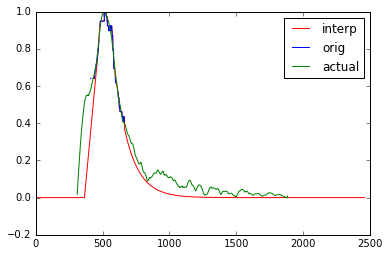

In [44]:

# PWG = df.PWG[5000*i]
test = df.PWG.unique()[i]
print test
PWG = df.PWG.unique()[i]

y = np.copy(df[df.PWG==PWG]['vortex'].values)
flow = np.copy(df[df.PWG==PWG]['flow'].values)

ynew,_ = nan_interp(np.copy(y))

plt.plot(ynew/ynew.max(),'r',label='interp')
plt.plot(y/np.nanmax(y), label='orig')
plt.plot(flow/np.nanmax(flow), 'g', label='actual')
plt.legend()
i = i+1

ATS24*23.0


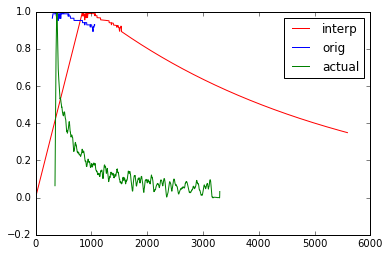

In [45]:

# PWG = df.PWG[5000*i]
test = df.PWG.unique()[i]
print test
PWG = df.PWG.unique()[i]

y = np.copy(df[df.PWG==PWG]['side_blended'].values)
flow = np.copy(df[df.PWG==PWG]['flow'].values)

ynew,_ = nan_interp(np.copy(y))

plt.plot(ynew/ynew.max(),'r',label='interp')
plt.plot(y/np.nanmax(y), label='orig')
plt.plot(flow/np.nanmax(flow), 'g', label='actual')
plt.legend()
i = i+1

In [46]:
df['imputed_vortex'] = np.ones(df.vortex.shape)
pwgs = df.PWG.unique()
for PWG in pwgs:
    y = np.copy(df[df.PWG==PWG]['vortex'].values)
    flow = np.copy(df[df.PWG==PWG]['flow'].values)
    y, addzeros = nan_interp(np.copy(y))
    y = y[addzeros:]
    df.imputed_vortex[df.PWG==PWG] = y
    

/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


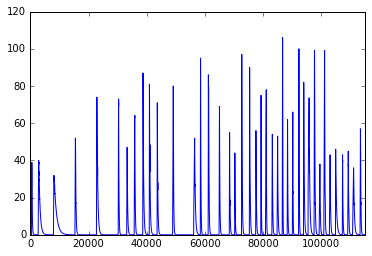

In [47]:
df.imputed_vortex.plot()

8
8
10
9
2
3
3
1
4


meta
Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)             8
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)       10
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)         9
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)        2
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)         3
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)        3
Sidestack A (Red)Downstream B (Green)Mouthpiece A (Red)0% Infill (Blue)               1
Sidestack A (Red)Downstream C (Yellow)Mouthpiece D (Red - Closed)0% Infill (Blue)     4
dtype: int64

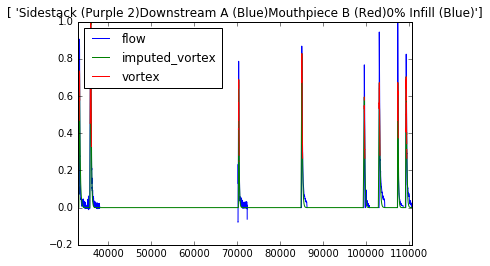

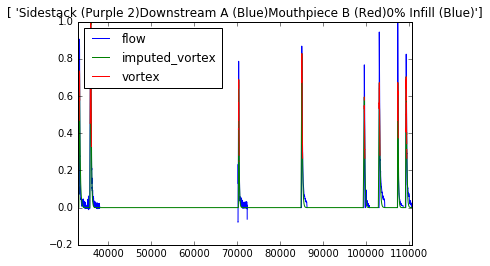

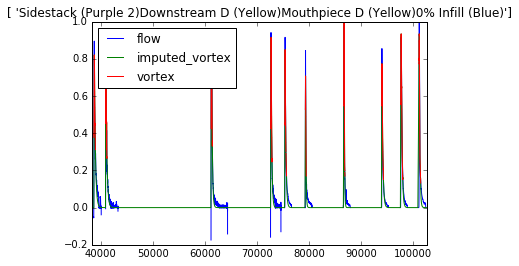

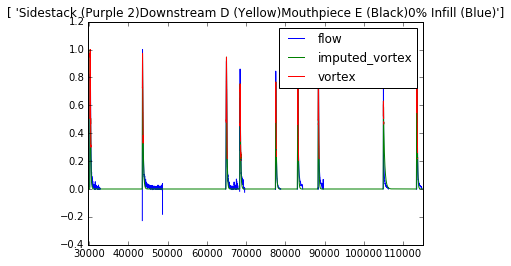

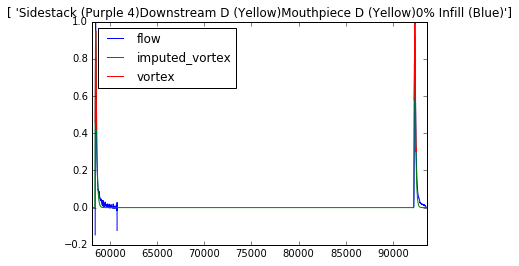

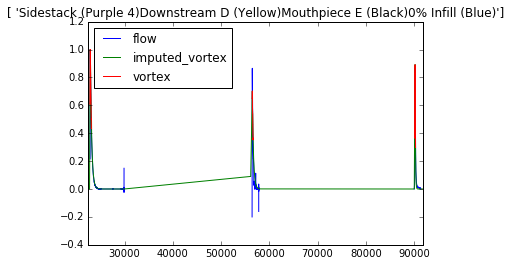

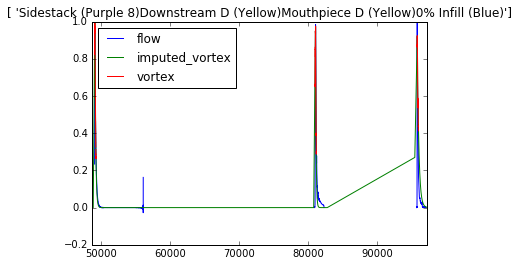

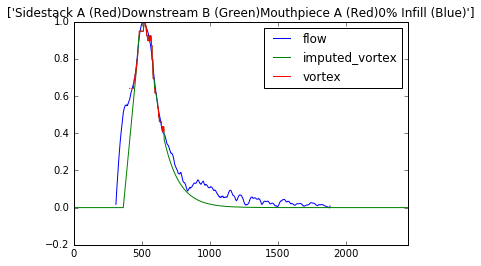

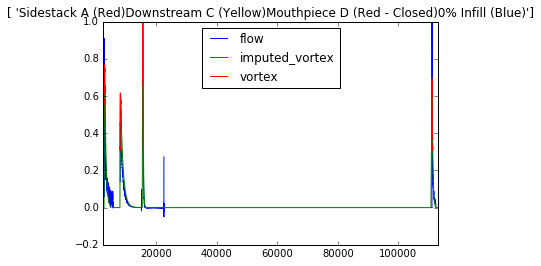

In [48]:
def analyze_groups(grp):
    print len(grp['PWG'].unique())
    plt.figure()
    (grp[['flow','imputed_vortex', 'vortex']]/grp[['flow','imputed_vortex', 'vortex']].max()).plot()
    plt.title(grp.meta.unique())
#     plt.legend(loc=3)
    return len(grp['PWG'].unique())

df_grouped = df.groupby('meta')
df_result = df_grouped.apply(analyze_groups)
df_result

In [49]:
df['flow_pred'] = np.zeros(df.flow.shape)
df.flow[df.flow<0]=0
df.flow[np.isnan(df.flow)]=0
df.side_f[np.isnan(df.side_f)]=0
df.side_h1[np.isnan(df.side_h1)]=0
df.side_blended[np.isnan(df.side_blended)] = 0
for grp_whistle in df['meta'].unique():
    grp = df[df.meta==grp_whistle]
    grps = grp['PWG'].unique()
    if len(grps)>1:
        for grp_pwg in grps:
            df_test = grp[grp['PWG']==grp_pwg]
            df_train = grp[grp['PWG']!=grp_pwg]

        #         feature_names = ['imputed_vortex']        
            feature_names = ['imputed_vortex','side_blended']

            X = df_train[feature_names].values
            y = df_train.flow.values
            y[np.isnan(y)] = 0
        #         idx = y>0.1
        #         y=y[idx]
        #         X=X[idx]

            Xtest = df_test[feature_names].values
            ytest = df_test.flow.values
            ytest[np.isnan(ytest)] = 0

            reg = lm.Ridge()
            yhat = reg.fit(X,y).predict(Xtest)
            yhat[yhat<0]=0

            df.flow_pred[(df.meta==grp_whistle)&(df['PWG']==grp_pwg)] = yhat
    
    


/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipyker

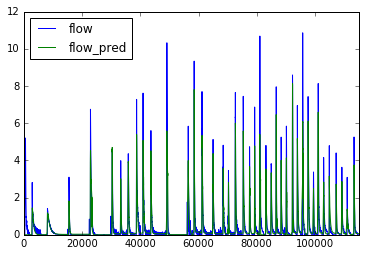

In [50]:
df[['flow','flow_pred']].plot()

{'boxes': [<matplotlib.lines.Line2D at 0x12062a690>],
 'caps': [<matplotlib.lines.Line2D at 0x1260a1110>,
 'fliers': [<matplotlib.lines.Line2D at 0x12311ab90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12311a3d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1214bb710>,
  <matplotlib.lines.Line2D at 0x1260a1c50>]}

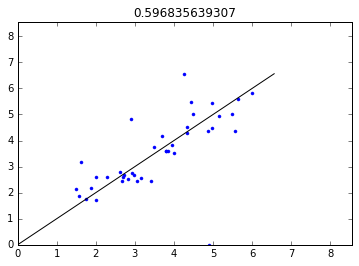

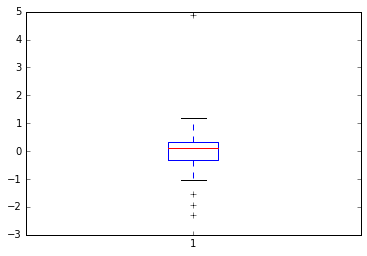

In [51]:
fs_effective = float(44100)/128.0
def calc_fvc(f):
    v = np.cumsum(f/fs_effective)
    return np.max(v)

def pd_fvc(grp):
    v1 = calc_fvc(grp['flow'])
    v2 = calc_fvc(medfilt(grp['flow_pred'].values,kernel_size=51))
    dfmeta = pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fvc','fvc_pred'])
    dfmeta['meta'] = grp.meta[grp.index[0]]
    return dfmeta

df_pwg = df.groupby('PWG')
fvc = df_pwg.apply(pd_fvc)
fvc['fvc_pred']= fvc['fvc_pred']
plt.plot(fvc['fvc'],fvc['fvc_pred'],'.')


plt.title(np.mean(np.abs(fvc['fvc']-fvc['fvc_pred'])))
mx = max(np.max(fvc['fvc']),np.max(fvc['fvc_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((fvc['fvc']-fvc['fvc_pred']))

# tmp.to_csv('FVCResults.csv')

In [52]:
# df[df.PWG=='ATS2626.0'][['flow','flow_pred']].plot()

{'boxes': [<matplotlib.lines.Line2D at 0x1206e5150>],
 'caps': [<matplotlib.lines.Line2D at 0x11af19e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x101b9b610>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x101b9b9d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1206e51d0>,
  <matplotlib.lines.Line2D at 0x11a454d50>]}

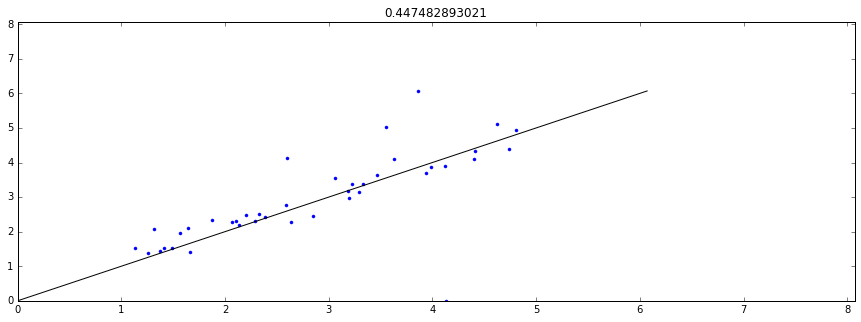

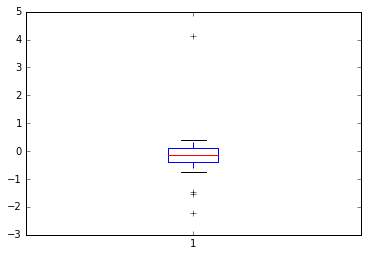

In [53]:
def calc_fev1(f):
    v = np.cumsum(f/float(fs_effective))
    t = np.array(range(len(v)))/float(fs_effective)
    zero_place = [t[np.nanargmax(f)]]
    
    t = t-zero_place[0]
#     plt.plot(t,v)
    t = t[t<=1.0]
    return v[len(t)]

def pd_fev1(grp):
    v1 = calc_fev1(grp['flow'].values)
    v2 = calc_fev1(medfilt(grp['flow_pred'].values,kernel_size=51))
    dfmeta = pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fev1','fev1_pred'])
    dfmeta['meta'] = grp.meta[grp.index[0]]
    return dfmeta

plt.figure(figsize=(15,5))
df_pwg = df.groupby('PWG')
fev1 = df_pwg.apply(pd_fev1)

# plt.plot(tmp['fev1'],tmp['fev1_pred'],'.')
# tmp['fev1_pred']= tmp['fev1_pred']-0.5
# plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1_pred'])))
# plt.xlim([0,2])
# tmp.to_csv('FEV1Results.csv')
fev1['fev1_pred']= fev1['fev1_pred']
plt.plot(fev1['fev1'],fev1['fev1_pred'],'.')


plt.title(np.mean(np.abs(fev1['fev1']-fev1['fev1_pred'])))
mx = max(np.max(fev1['fev1']),np.max(fev1['fev1_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((fev1['fev1']-fev1['fev1_pred']))



{'boxes': [<matplotlib.lines.Line2D at 0x1240316d0>],
 'caps': [<matplotlib.lines.Line2D at 0x124033510>,
 'fliers': [<matplotlib.lines.Line2D at 0x1245b5810>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1245b51d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1240317d0>,
  <matplotlib.lines.Line2D at 0x124031e90>]}

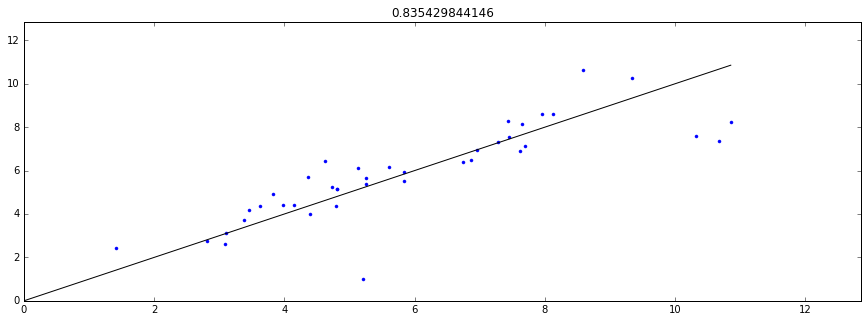

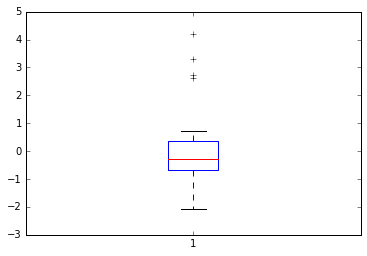

In [54]:
def calc_pef(f):
    return np.max(f)

def pd_pef(grp):
    v1 = calc_pef(grp['flow'].values)
    v2 = calc_pef(medfilt(grp['flow_pred'].values,kernel_size=51))
    dfmeta = pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['pef','pef_pred'])
    dfmeta['meta'] = grp.meta[grp.index[0]]
    return dfmeta

plt.figure(figsize=(15,5))
df_pwg = df.groupby('PWG')
pef = df_pwg.apply(pd_pef)

# plt.plot(tmp['fev1'],tmp['fev1_pred'],'.')
# tmp['fev1_pred']= tmp['fev1_pred']-0.5
# plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1_pred'])))
# plt.xlim([0,2])
# tmp.to_csv('FEV1Results.csv')
pef['pef_pred']= pef['pef_pred']*1.2+1
plt.plot(pef['pef'],pef['pef_pred'],'.')


plt.title(np.mean(np.abs(pef['pef']-pef['pef_pred'])))
mx = max(np.max(pef['pef']),np.max(pef['pef_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((pef['pef']-pef['pef_pred']))



Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)
Sidestack A (Red)Downstream B (Green)Mouthpiece A (Red)0% Infill (Blue)
Sidestack A (Red)Downstream C (Yellow)Mouthpiece D (Red - Closed)0% Infill (Blue)


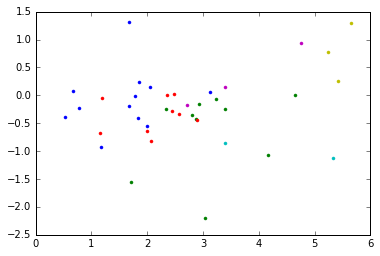

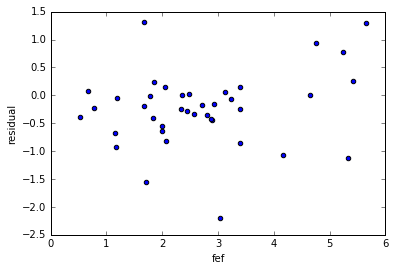

In [55]:
def calc_fef(f):
    v = np.cumsum(f/fs_effective)
    vmax = np.max(v)
    
    return np.mean(f[(v>0.25*vmax)&(v<0.75*vmax)])

def pd_fef(grp):
#     print 'Entering'

#     print grp.meta[grp.index[0]]
    v1 = calc_fef(grp['flow'].values)
    v2 = calc_fef(medfilt(grp['flow_pred'].values,kernel_size=51))
    dfmeta = pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fef','fef_pred'])
    dfmeta['meta'] = grp.meta[grp.index[0]]
#     print 'Exiting'
    return dfmeta

df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fef)
tmp['fef_pred']= tmp['fef_pred']

groups = tmp.groupby('meta')

for name, group in groups:
    print name
    plt.plot(group['fef'],group['fef']-group['fef_pred'],'.',label=name)

# plt.legend(loc='lower right')
# plt.title(np.mean(np.abs(tmp['fef']-tmp['fef_pred'])))
# mx = max(np.max(tmp['fef']),np.max(tmp['fef_pred']))
# plt.plot([0,mx],[0,mx],'k')
# plt.ylim([0, mx+2])
# plt.xlim([0, mx+2])

plt.figure()
tmp['residual'] = tmp['fef']-tmp['fef_pred']
groups = tmp.groupby('meta')
tmp.plot(kind='scatter',x='fef',y='residual')


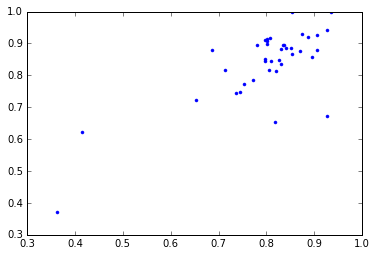

In [56]:
fvc['fev1p'] = fev1['fev1']/fvc['fvc']
fvc['fev1p_pred'] = fev1['fev1_pred']/fvc['fvc_pred']


plt.plot(fvc['fev1p'],fvc['fev1p_pred'],'.')

/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-0.2, 0.2)

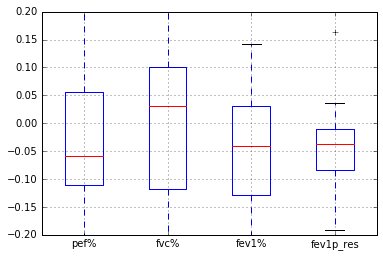

In [87]:
master_df = pd.DataFrame(data=np.array([
            pef['pef'].values-pef['pef_pred'].values,
            fev1['fev1'].values-fev1['fev1_pred'].values,
            fvc['fvc'].values-fvc['fvc_pred'].values,
            fvc['fev1p'].values-fvc['fev1p_pred'].values,
            pef['pef'],fev1['fev1'],fvc['fvc'],fvc['fev1p'],
            pef['pef_pred'],fev1['fev1_pred'],fvc['fvc_pred'],fvc['fev1p_pred'],
        ]).T,
         columns=['pef_res','fev1_res','fvc_res','fev1p_res',
                 'pef','fev1','fvc','fev1p','pef_pred','fev_pred','fvc_pred','fev1p_pred'])

# master_df[['pef_res','fvc_res','fev1_res','fev1p_res']].boxplot()

master_df['pef%'] = master_df['pef_res']/master_df['pef']
master_df['fvc%'] = master_df['fvc_res']/master_df['fvc']
master_df['fev1%'] = master_df['fev1_res']/master_df['fev1']


master_df[['pef%','fvc%','fev1%','fev1p_res']].boxplot()
plt.ylim([-.20,.20])